In [1]:
import pandas as pd
import numpy as np
import tqdm
import itertools

import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

In [2]:
### LOAD DATA ###
df = pd.read_csv('Steel_Plates_Faults.csv')
label = df.Fault
df = df.drop('Fault',axis=1)

print(df.shape)
df.head()

(1941, 27)


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000


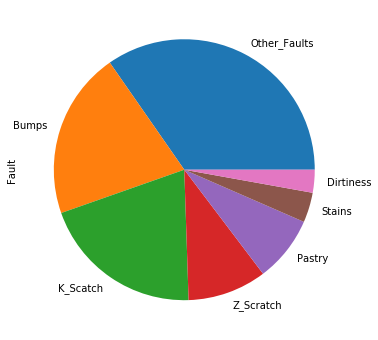

In [3]:
### TARGET DISTRIBUTION ###
label.value_counts().plot.pie(figsize=(6,6))

In [4]:
### GENERATE TRAIN TEST ###
X_train, X_test, y_train, y_test = train_test_split(df, label, random_state = 42,test_size=0.2)
print("train:", X_train.shape, "test:", X_test.shape)

train: (1552, 27) test: (389, 27)


# FIRST MODEL

In [5]:
rfc = GradientBoostingClassifier(n_estimators=500)
rfc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [6]:
print(accuracy_score(y_test, rfc.predict(X_test)))
print(classification_report(y_test, rfc.predict(X_test)))

0.8071979434447301
              precision    recall  f1-score   support

       Bumps       0.64      0.72      0.68        72
   Dirtiness       0.55      0.75      0.63         8
    K_Scatch       0.95      0.95      0.95        83
Other_Faults       0.78      0.78      0.78       143
      Pastry       0.76      0.55      0.64        29
      Stains       1.00      0.92      0.96        13
   Z_Scratch       1.00      0.93      0.96        41

   micro avg       0.81      0.81      0.81       389
   macro avg       0.81      0.80      0.80       389
weighted avg       0.81      0.81      0.81       389



In [7]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

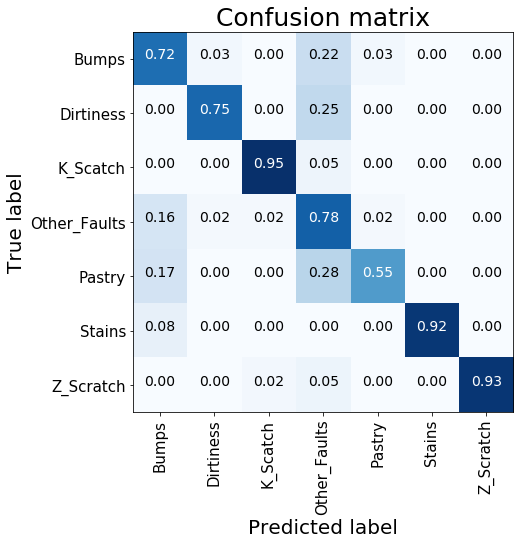

In [8]:
plt.figure(figsize=(7,7))

cnf_matrix = confusion_matrix(y_test, rfc.predict(X_test))
plot_confusion_matrix(cnf_matrix, classes=np.unique(label), title="Confusion matrix")

# VISUALIZATION

In [9]:
### PLOT WITH OTHER_FAULTS ###
scaler = StandardScaler()

tsne = TSNE(n_components=2, random_state=42, n_iter=300, perplexity=5)
T = tsne.fit_transform(scaler.fit_transform(df.astype('float64')))

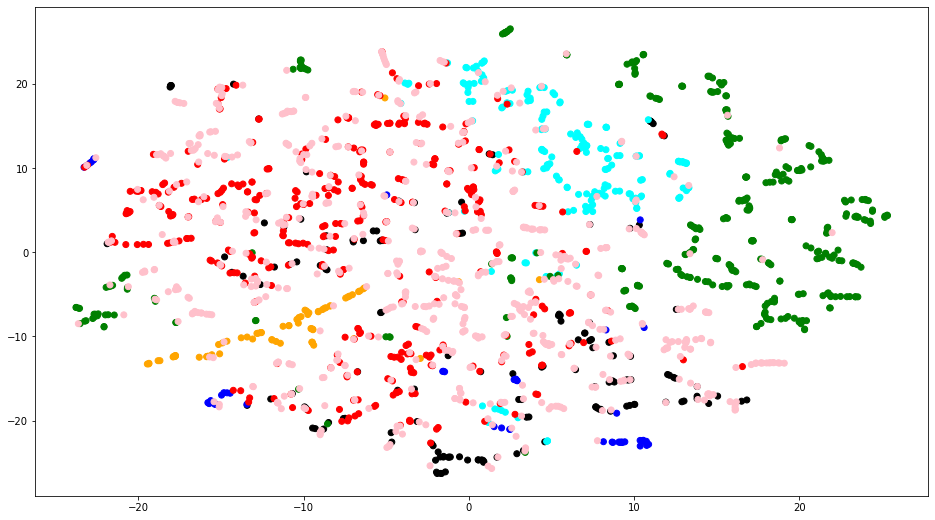

In [10]:
plt.figure(figsize=(16,9))

colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan'}
plt.scatter(T.T[0], T.T[1], c=[colors[i] for i in LabelEncoder().fit_transform(label)]) 

In [11]:
### PLOT WITHOUT OTHER_FAULTS ###
tsne = TSNE(n_components=2, random_state=42, n_iter=300, perplexity=5)
T = tsne.fit_transform(scaler.transform(df[label != 'Other_Faults'].astype('float64')))

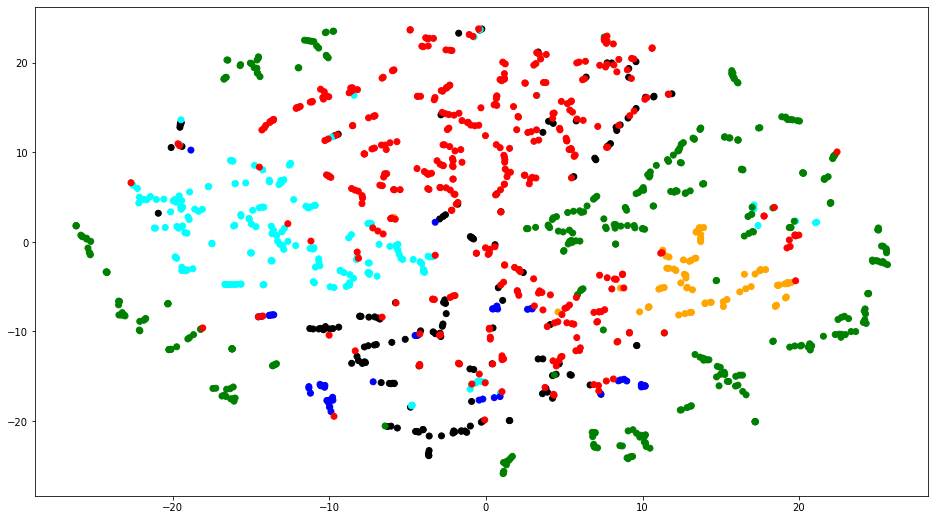

In [12]:
plt.figure(figsize=(16,9))

colors = {0:'red', 1:'blue', 2:'green', 3:'black', 4:'orange', 5:'cyan'}
plt.scatter(T.T[0], T.T[1], c=[colors[i] for i in LabelEncoder().fit_transform(label[label != 'Other_Faults'])])

In [13]:
### EXCLUDE OTHER_FAULTS FROM TRAIN TEST ###
X_train2, y_train2 = X_train[y_train != 'Other_Faults'].copy(), y_train[y_train != 'Other_Faults'].copy()
X_test2, y_test2 = X_test[y_test != 'Other_Faults'].copy(), y_test[y_test != 'Other_Faults'].copy()

print("train:", X_train2.shape, "test:", X_test2.shape)

train: (1022, 27) test: (246, 27)


# SECOND MODEL

In [14]:
rfc = GradientBoostingClassifier(n_estimators=500)
rfc.fit(X_train2, y_train2)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [15]:
print(accuracy_score(y_test2, rfc.predict(X_test2)))
print(classification_report(y_test2, rfc.predict(X_test2)))

0.9065040650406504
              precision    recall  f1-score   support

       Bumps       0.83      0.86      0.84        72
   Dirtiness       0.88      0.88      0.88         8
    K_Scatch       1.00      0.98      0.99        83
      Pastry       0.69      0.69      0.69        29
      Stains       1.00      0.92      0.96        13
   Z_Scratch       1.00      1.00      1.00        41

   micro avg       0.91      0.91      0.91       246
   macro avg       0.90      0.89      0.89       246
weighted avg       0.91      0.91      0.91       246



# CREATE THRESHOLD

In [16]:
def predict(feature, threshold_map=None): 

    confidence = rfc.predict_proba(feature).max()
    label = rfc.predict(feature)[0]

    if threshold_map and label in threshold_map:
        if confidence >= threshold_map[label]:
            return {"label": label, "confidence": confidence}     
        
        else:
            return {"label": "OTHERS", "confidence": confidence}
    
    elif threshold_map == None:
        return {"label": label, "confidence": confidence}
    
    else:
        print(label, 'not in threshold map')

In [17]:
### TRY PREDICT FUNCTION ###
predict([df[label == 'Other_Faults'].values[4]])

{'label': 'Z_Scratch', 'confidence': 0.6507177009574616}

In [18]:
### MAKE PRED ON OTHER_FAULTS ### 

pred_lab = []
pred_conf = []
for row in tqdm.tqdm(df[label == 'Other_Faults'].values):
    pred = predict([row])
    pred_lab.append(pred['label'])
    pred_conf.append(pred['confidence'])

100%|███████████████████████████████████████████████████████████████████████████████| 673/673 [00:01<00:00, 612.34it/s]


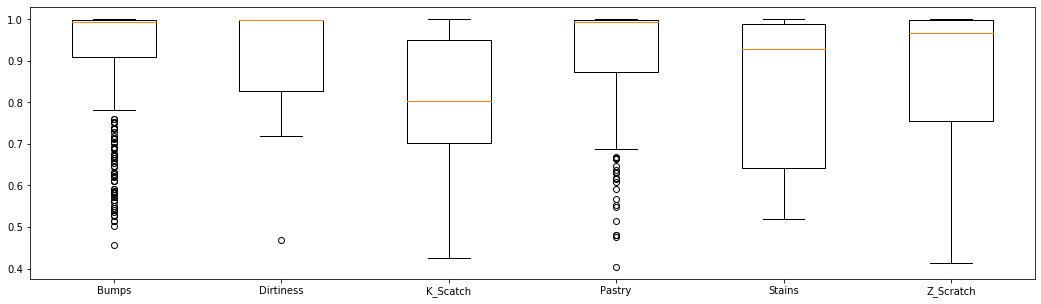

In [19]:
### PLOT SCORES ###
other_pred = pd.DataFrame({'label':pred_lab, 'pred':pred_conf})
diz_score = other_pred.groupby('label')['pred'].apply(list).to_dict()

plt.figure(figsize=(18,5))

plt.boxplot(diz_score.values(), labels=diz_score.keys())

plt.grid(False); plt.show()

In [20]:
### IMPOSE 30 PERCENTILE THRESHOLD ###
threshold_p= {}
for lab in diz_score.keys():

    threshold_p[lab] = np.percentile(diz_score[lab],30)

print(threshold_p)

{'Bumps': 0.9436590669522296, 'Dirtiness': 0.8848678660640525, 'K_Scatch': 0.7287108272248142, 'Pastry': 0.9086007135976988, 'Stains': 0.7289536259891848, 'Z_Scratch': 0.787447112673171}


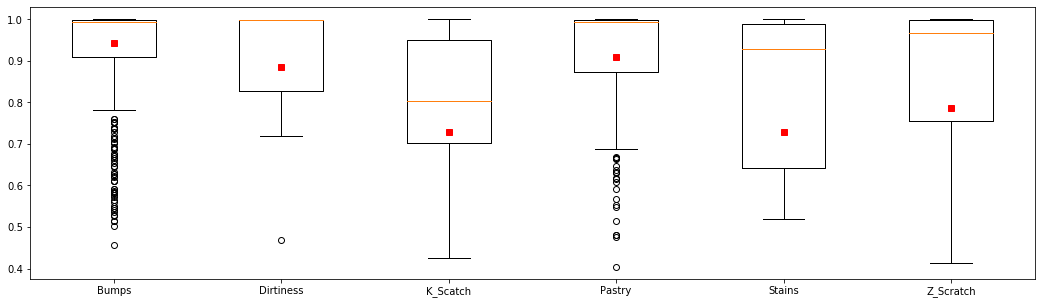

In [21]:
### PLOT SCORES WITH THRESHOLD ###
plt.figure(figsize=(18,5))

plt.boxplot(list(diz_score.values()), labels=list(diz_score.keys()))
plt.plot(range(1,len(threshold_p.keys())+1), list(threshold_p.values()), 'rs')

plt.grid(False); plt.show()

In [22]:
### MAKE PREDICTION ON TEST WITHOT OTHER_FAULTS + THRESHOLD ###
final_pred = []
for row in tqdm.tqdm(X_test2.values):
    final_pred.append(predict([row], threshold_map=threshold_p)["label"])

100%|███████████████████████████████████████████████████████████████████████████████| 246/246 [00:00<00:00, 621.31it/s]


In [23]:
print(accuracy_score(y_test2, final_pred))
print(classification_report(y_test2, final_pred))

0.8617886178861789


C:\Users\marco.cerliani\AppData\Local\Continuum\anaconda3\envs\keras\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

       Bumps       0.90      0.83      0.86        72
   Dirtiness       0.86      0.75      0.80         8
    K_Scatch       1.00      0.98      0.99        83
      OTHERS       0.00      0.00      0.00         0
      Pastry       0.68      0.52      0.59        29
      Stains       1.00      0.92      0.96        13
   Z_Scratch       1.00      0.93      0.96        41

   micro avg       0.86      0.86      0.86       246
   macro avg       0.78      0.70      0.74       246
weighted avg       0.93      0.86      0.89       246



In [24]:
### TRY TO PREDICT ONLY OTHER_FAULTS ###
other_final_pred = []
for row in tqdm.tqdm(df.values):
    other_final_pred.append(predict([row], threshold_map=threshold_p)["label"])

100%|█████████████████████████████████████████████████████████████████████████████| 1941/1941 [00:03<00:00, 552.27it/s]


In [25]:
pd.value_counts(other_final_pred)

Bumps        677
K_Scatch     437
Pastry       255
OTHERS       222
Z_Scratch    215
Stains        75
Dirtiness     60
dtype: int64

# FINAL VISUALIZATION

In [26]:
### PLOT WITH THE 'NEW' OTHER_FAULTS CLASS ###

tsne = TSNE(n_components=2, random_state=42, n_iter=300, perplexity=5)
T = tsne.fit_transform(scaler.transform(df.astype('float64')))

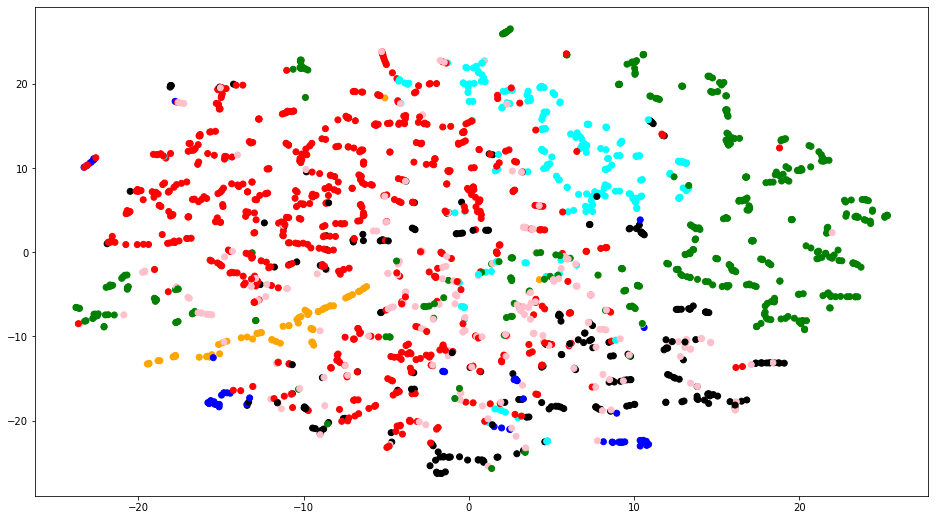

In [27]:
plt.figure(figsize=(16,9))

colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan'}
plt.scatter(T.T[0], T.T[1], c=[colors[i] for i in LabelEncoder().fit_transform(other_final_pred)]) 

# FINAL MODEL

In [28]:
### MAKE A MODEL WITH THE 'NEW' OTHER_FAULTS CLASS ###
X_train3, X_test3, y_train3, y_test3 = train_test_split(df, other_final_pred, random_state=42, test_size=0.2)
print("train:", X_train3.shape, "test:", X_test3.shape)

train: (1552, 27) test: (389, 27)


In [29]:
rfc3 = GradientBoostingClassifier(n_estimators=500)
rfc3.fit(X_train3, y_train3)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [30]:
print(accuracy_score(y_test3, rfc3.predict(X_test3)))
print(classification_report(y_test3, rfc.predict(X_test3)))

0.8611825192802056


C:\Users\marco.cerliani\AppData\Local\Continuum\anaconda3\envs\keras\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       Bumps       0.81      1.00      0.89       128
   Dirtiness       0.91      1.00      0.95        10
    K_Scatch       0.96      1.00      0.98        92
      OTHERS       0.00      0.00      0.00        61
      Pastry       0.70      1.00      0.83        45
      Stains       1.00      1.00      1.00        13
   Z_Scratch       0.87      1.00      0.93        40

   micro avg       0.84      0.84      0.84       389
   macro avg       0.75      0.86      0.80       389
weighted avg       0.72      0.84      0.77       389

